# Compare MD Trajectory from MACE to NWChem
See if each model captures the disassociation correctly.

In [76]:
from matplotlib import pyplot as plt
from ase.md.nvtberendsen import NVTBerendsen
from ase import Atoms, units
from ase.io import iread, read
from pathlib import Path
from mace.calculators import MACECalculator
import torch
import shutil

Create a list of models to evaluate, set the directory of the simulation, and create a path for outputs

In [77]:
models_list = ["mace_run-21940057", "mace_run-27650412"]
molecule_name = "propanol"

md_dir = f"../data/md-runs/{molecule_name}"
initial_state = f"../data/raw-data/{molecule_name}.xyz"

outputs_dir = "data"
if not Path(outputs_dir).exists():
    outputs_dir.mkdir()

In [78]:
models = {}
for model in models_list:
    models[model] = f"../runs/checkpoints/{model}.model"

Read the initial position of the atoms from the xyz file, and read the trajectory data saved from the earlier molecular dynamics simulation

In [79]:
#starting_atoms = read(initial_state, index='0')
starting_atoms = read("../data/md-runs/propanol/md.traj", index="0")
traj = {'HF//6-31G*': [a for a in read(f'{md_dir}/md-run.xyz', index=':')]}

In [80]:
def run_md(starting_atoms: Atoms, calc, traj_file: str, xyz_file: str, timesteps: int = 2000, temp_K: float = 298.15) -> list[Atoms]:
    """Run MD using the same procedure that we used to generate the NWChem trajectory
    
    Args:
        starting_atoms: Starting point for the run
        calc: Calculator used for forces 
        timesteps: Number of timesteps to run
    """
    atoms = starting_atoms.copy()
    #atoms.set_calculator()
    md = NVTBerendsen(atoms, timestep=10 * units.AUT,
                      temperature_K=temp_K, taut=0.2 * units.fs,
                      trajectory=traj_file)
    atoms.calc = calc

    #Write the calculated xyz file
    def write_frame():
        atoms.write(xyz_file, format='extxyz', append=True)

    # Attach the write function to the dynamics
    md.attach(write_frame, interval=1)

    md.run(timesteps)
    return [frame for frame in iread(traj_file)]


Run MACECalculator for each model

In [81]:
for name, path in models.items():
    traj_file = f"{outputs_dir}/{name}.traj"
    xyz_file = f"{outputs_dir}/{name}.xyz"
    if Path(f"{outputs_dir}/{model}.xyz").exists():
        traj[name] = [frame for frame in iread(traj_file)]
    else:
        traj[name] = run_md(starting_atoms, MACECalculator(model_path=path, device='cuda'), traj_file=traj_file, xyz_file=xyz_file)

Plot trajectory performance

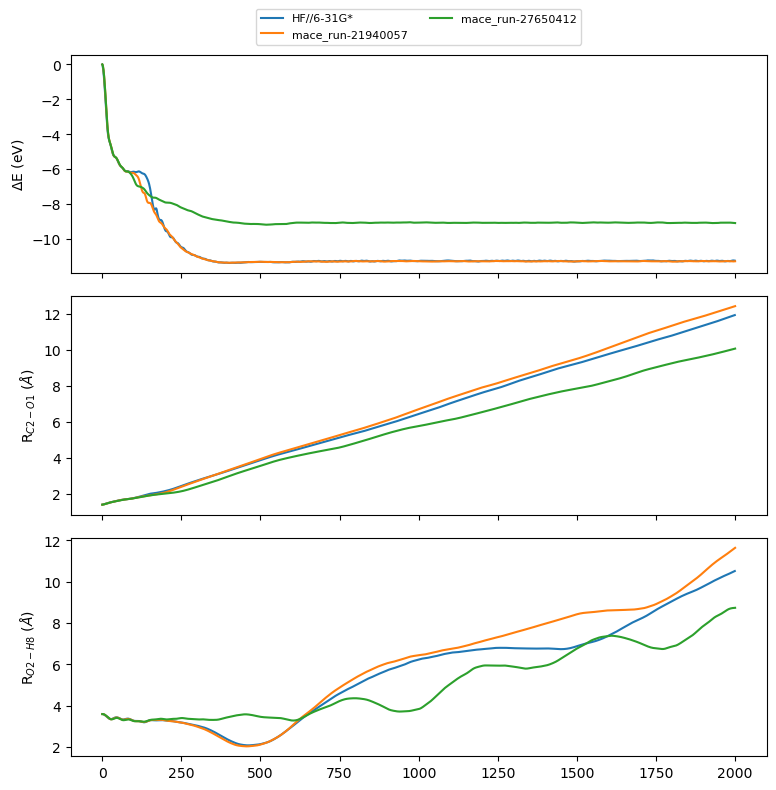

In [82]:
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(8, 8))

for name, t in traj.items():
    linestyle='--' if name == 'nwchem' else '-'
    e0 = t[0].get_potential_energy() 
    axs[0].plot([a.get_potential_energy() - e0 for a in t], label=name, linestyle=linestyle)
    axs[1].plot([a.get_distance(1, 2) for a in t], linestyle=linestyle)
    axs[2].plot([a.get_distance(12, 10) for a in t], linestyle=linestyle)
    
axs[0].set_ylabel('$\Delta$E (eV)')
axs[1].set_ylabel('R$_{C2-O1}$ ($\\AA$)')
axs[2].set_ylabel('R$_{O2-H8}$ ($\\AA$)')
    
axs[0].legend(fontsize=8, bbox_to_anchor=(0.5, 1.02), loc='lower center', ncol=2)
fig.tight_layout()